# Variability of test error

The test error is a stand-in for the generalisation error. Sometimes it is actually taken to be *equal* to the generalisation error. This is clearly incorrect: the test error, by the choice of the test set, is also subject of statistical fluctuations. As one should expect, these fluctuations are larger if the test is smaller. 

We consider the [MNIST](https://en.wikipedia.org/wiki/MNIST_database) data set (recognition of handwritten digits) again to have a look at this effect.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8")   # for nicer plots
import sklearn
from sklearn.metrics import zero_one_loss
from sklearn.tree import DecisionTreeClassifier

Let's load the MNIST data set.

In [2]:
# fetch data from openml.org
# see https://en.wikipedia.org/wiki/MNIST_database
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, cache=True)
mnist.target = mnist.target.astype(int) # fetch_openml() returns targets as strings
X, y = mnist["data"], mnist["target"]

/home/henning/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


We split off a training set and train a decision tree on it.

In [3]:
X, y = sklearn.utils.shuffle(X,y)   # we randomly permute the order of the data
train_size=20000   # we pick a smallish set as training set, mainly so that the code runs faster
X_train, X_test, y_train, y_test = X[:train_size], X[train_size:], y[:train_size], y[train_size:]

# we fix the depth of the decision tree to 12, which seems like a reasonable value
tree=DecisionTreeClassifier(max_depth=12)
tree.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=12)

Next, we repeatedly draw a test set of varying sizes from the part of the data that wasn't used for training. We record the test errors and do a scatter plot.

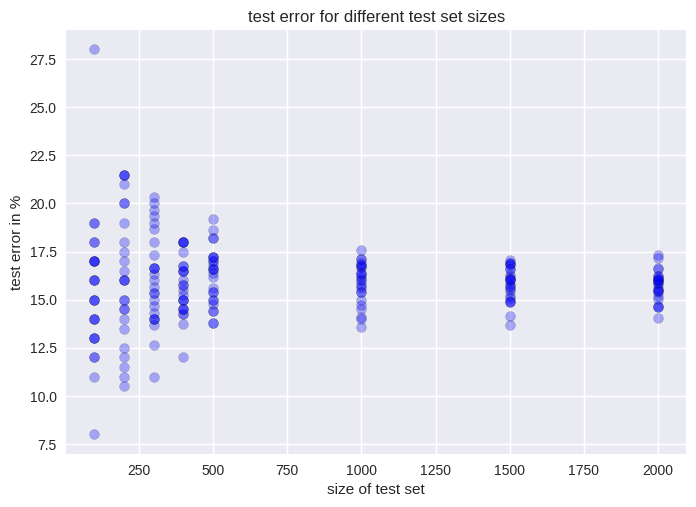

In [4]:
test_errs=[]
sizes=[]
for test_size in [100,200,300,400,500,1000,1500,2000]:
    XX,yy=sklearn.utils.shuffle(X_test,y_test)
    for i in range(25):  # we draw 25 test sets of the given size and compute the test error
        sizes.append(test_size)
        X_t,y_t=XX[i*test_size:(i+1)*test_size],yy[i*test_size:(i+1)*test_size]
        test_errs.append(zero_one_loss(tree.predict(X_t),y_t)*100)
fig,ax=plt.subplots()
ax.scatter(sizes,test_errs,alpha=0.3,s=50,c='b',edgecolor='black')
ax.set_xlabel('size of test set')
ax.set_ylabel('test error in %')
ax.set_title('test error for different test set sizes')
plt.savefig('testerr.png',dpi=300)
plt.show()

What we see: Variability of the test error is much larger for small test set size. Obviously, this is not really surprising: a larger test set simply gives a more accurate picture of the generalisation error. Thus, it's important that the test set is sufficiently large, too. As the training set also should better be larger, we need quite a lot of data. Better call google. (They sit on *all* the data.)

Let's do this again, but let's have a closer look at test set size 500. With that size we can draw 100 disjoint test sets from the portion of the dataset that was not used for testing. We compute the test errors and plot a histogram. 

5/95 percentile of test error: (13.2%,18.2%)


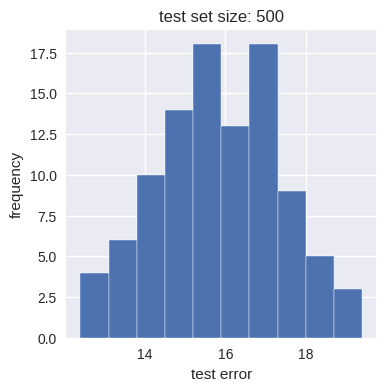

In [25]:
# draw disjoint test sets and compute error
test_size=500
num_test_sets=len(X_test)//test_size
test_errs=[]
for i in range(num_test_sets):
    X_t=X_test[i*test_size:(i+1)*test_size]
    y_t=y_test[i*test_size:(i+1)*test_size]
    test_errs.append(zero_one_loss(tree.predict(X_t),y_t)*100)    

# plot histogram of test set errors
fig,ax=plt.subplots(figsize=(4,4))
ax.hist(test_errs,bins=10,edgecolor="white")
ax.set_xlabel("test error")
ax.set_ylabel("frequency")
ax.set_title("test set size: {}".format(test_size))
five_perc=np.percentile(test_errs,5)
ninetyfive_perc=np.percentile(test_errs,95)
print("5/95 percentile of test error: ({:.1f}%,{:.1f}%)".format(five_perc,ninetyfive_perc))

We see that with this, admittedly tiny, test set size, the test error fluctuates between 13% and 18%. 

Do you know kaggle? It's a website (https://kaggle.com) that hosts machine learning competitions with sometimes substantial cash prizes. It works as follows: they provide the training set and keep the test set hidden. At the end the algorithms are compared on the test set and the prize awarded to the participant with smallest test error. Interestingly, the differences in performance for the first three slots is sometimes very small -- in fact, so small that I would guess that it is within the natural variance of the test error. It could be sheer luck whether you end up with first prize or second prize (assuming your algorithm is vying for the top slot -- which does take skill).